In [ ]:
# !apt-get install tree
# !pip install tensorflow-gpu==1.15.3

# import libs

In [2]:
import tensorflow as tf
#--------------------------------------
print(tf.__version__)
# print(tf.config.list_physical_devices('GPU'))

/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/py

2.2.0


In [3]:
from tensorflow.compat.v1.keras import backend as K
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)
K.set_session(sess)

In [4]:
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Conv2D, add, BatchNormalization, Dropout, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Model 
import cv2
import numpy as np
import pandas as pd
# from tqdm import tqdm
import os
# from google.colab import drive
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation

In [11]:
imgs_paths = glob("../UTKface/*.jpg")
im =Image.open(imgs_paths[25])
im.size


(818, 999)

**Labels**<br>
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

* [age] is an integer from 0 to 116, indicating the age
* [gender] is either 0 (male) or 1 (female)
* [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
* [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [14]:
# imgs_paths = glob(os.path.join('..', 'UTKface','*.jpg'))
# img_data = {'img_path':[], 'age':[], 'gender': [], 'race': []}
# for img in imgs_paths:
#   img_split = os.path.split(img)[-1].split('_')
#   if len (img_split) == 4 and img_split[0].isalnum() and img_split[1].isalnum() and img_split[2].isalnum():
#     img_data['img_path'].append(img)
#     img_data['age'].append(int(img_split[0]))
#     img_data['gender'].append(int(img_split[1]))
#     img_data['race'].append(int(img_split[2]))

# img_df = pd.DataFrame(img_data)
# # shuffle dataframe
# img_df = img_df.sample(frac=1).reset_index(drop=True)
# no_race_classes = len(img_df.race.unique())
# # mu = img_df['age'].mean()
# # sigma = img_df['age'].std()
# # img_df['age'] = (img_df['age']-mu)/sigma
# max_age = img_df['age'].max()
# img_df['age'] = img_df['age'] / max_age
# img_df.head()

In [243]:
# # split data
# w, h = 160, 160 
# msk = np.random.rand(len(img_df)) < 0.8
# train = img_df[msk].reset_index()
# valid = img_df[~msk].reset_index()
# print(len(train), len(valid))

0.24561126879007675


In [244]:
max_age = 116
TRAINING_PATH = os.path.join('..', 'dataset', 'train_cropped.csv')
VALID_PATH = os.path.join('..', 'dataset', 'valid_cropped.csv')
train = pd.read_csv(TRAINING_PATH)
valid = pd.read_csv(VALID_PATH)
train.img_path = '../UTKface/'+ train.img_path
valid.img_path = '../UTKface/'+ valid.img_path
no_race_classes = train.race.unique().size
df = pd.concat((train, valid))
# train.age = np.round(train.age * max_age,0)
# valid.age = np.round(valid.age * max_age,0)
train.head()

FileNotFoundError: [Errno 2] File dataWithAUg.csv does not exist: 'dataWithAUg.csv'

In [17]:

# valid_coroped_idx = []
# train_coroped_idx = []
# for i in range(train.shape[0]):
#     croped = train.img_path.loc[i].split('.')[-2] == 'chip'
#     if croped:
#         train_coroped_idx.append(i)
# for i in range(valid.shape[0]):
#     croped = valid.img_path.loc[i].split('.')[-2] == 'chip'
#     if croped:
#         valid_coroped_idx.append(i)
        
# train_cropped = train.loc[train_coroped_idx]
# valid_cropped = valid.loc[valid_coroped_idx]

# train_cropped.to_csv('../dataset/train_cropped.csv',index=False)
# valid_cropped.to_csv('../dataset/valid_cropped.csv',index=False)


Standard Scaler = (xi - mu)/ sigma

In [18]:
# mu = train.age.mean()
# sigma = train.age.std()
# train.age = (train.age - mu)/sigma
# valid.age = (valid.age - mu)/sigma

---

Robust Scaler = (xi - q1) / (q3 - q1)

In [19]:
q1, q3 = train.age.quantile([0.25,0.75]).to_list()
iqr = q3-q1
train.age = (train.age - q1)/iqr
valid.age = (valid.age - q1)/iqr

In [20]:
q1, iqr

(23.0, 22.0)

In [21]:
train.age.min(), train.age.max()

(-1.0, 4.2272727272727275)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5b4b2fc88>,
      dtype=object)

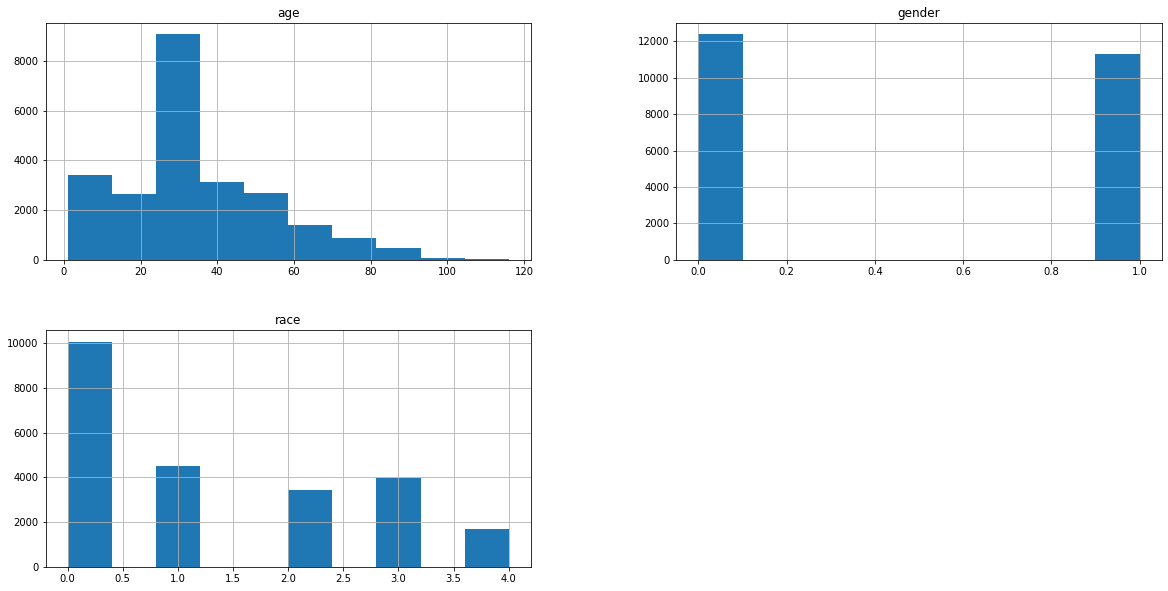

In [195]:
df.hist(figsize=(20,10))

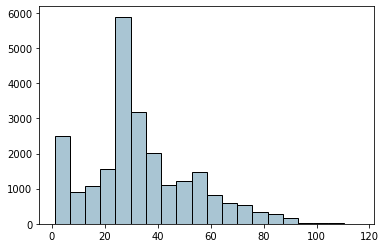

In [196]:
df.age.hist(bins=20, color='#A9C5D3', edgecolor='black',  
                          grid=False)

## fixed binning

In [217]:
# df['age_5y_lable'] = (df.age//5).astype('int')
bin_edges = list(range(0,125,5))
bin_lables = list(range(0, len(bin_edges)-1))

df['age_fixed_5y_lable'] = pd.cut(np.array(df['age']), bins=bin_edges, labels=bin_lables)
df['age_fixed_5y_range'] = pd.cut(np.array(df['age']), bins=bin_edges)


In [218]:
df

,img_path,age,gender,race,age_fixed_5y_lable,age_fixed_5y_range
0,../UTKface/27_1_1_20170117013822716.jpg.chip.jpg,27.0,1,1,5,"(25, 30]"
1,../UTKface/45_0_3_20170119201729135.jpg.chip.jpg,45.0,0,3,8,"(40, 45]"
2,../UTKface/23_0_1_20170114034248958.jpg.chip.jpg,23.0,0,1,4,"(20, 25]"
3,../UTKface/24_0_0_20170113142022092.jpg.chip.jpg,24.0,0,0,4,"(20, 25]"
4,../UTKface/28_1_2_20170116170001611.jpg.chip.jpg,28.0,1,2,5,"(25, 30]"
...,...,...,...,...,...,...
4668,../UTKface/68_0_0_20170117174131505.jpg.chip.jpg,68.0,0,0,13,"(65, 70]"
4669,../UTKface/50_1_0_20170110123120845.jpg.chip.jpg,50.0,1,0,9,"(45, 50]"
4670,../UTKface/28_0_0_20170113132654464.jpg.chip.jpg,28.0,0,0,5,"(25, 30]"
4671,../UTKface/26_1_3_20170119192426755.jpg.chip.jpg,26.0,1,3,5,"(25, 30]"


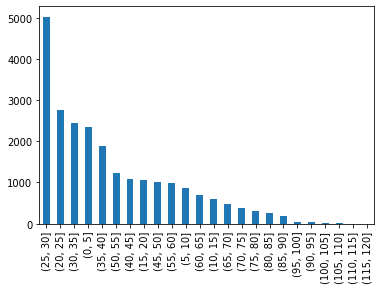

In [235]:
pd.value_counts(df['age_fixed_5y_range']).plot.bar()

## custom binning

In [236]:
bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80, 120]
bin_lables = list(range(0, len(bin_edges)-1))

df['Age_bin_custom_label'] = pd.cut(np.array(df['age']), bins=bin_edges, labels=bin_lables)
df['Age_bin_custom_range'] = pd.cut(np.array(df['age']), bins=bin_edges)


In [226]:
df[df['age']==65]

,img_path,age,gender,race,age_fixed_5y_lable,age_fixed_5y_range,Age_bin_custom_label,Age_bin_custom_range
220,../UTKface/65_0_0_20170103183632050.jpg.chip.jpg,65.0,0,0,12,"(60, 65]",12,"(60, 70]"
303,../UTKface/65_0_0_20170117160712302.jpg.chip.jpg,65.0,0,0,12,"(60, 65]",12,"(60, 70]"
345,../UTKface/65_0_0_20170111224012460.jpg.chip.jpg,65.0,0,0,12,"(60, 65]",12,"(60, 70]"
349,../UTKface/65_0_1_20170111200815149.jpg.chip.jpg,65.0,0,1,12,"(60, 65]",12,"(60, 70]"
354,../UTKface/65_1_0_20170120223955918.jpg.chip.jpg,65.0,1,0,12,"(60, 65]",12,"(60, 70]"
...,...,...,...,...,...,...,...,...
4292,../UTKface/65_0_0_20170104213544876.jpg.chip.jpg,65.0,0,0,12,"(60, 65]",12,"(60, 70]"
4308,../UTKface/65_0_0_20170104184609437.jpg.chip.jpg,65.0,0,0,12,"(60, 65]",12,"(60, 70]"
4417,../UTKface/65_0_0_20170104213032541.jpg.chip.jpg,65.0,0,0,12,"(60, 65]",12,"(60, 70]"
4516,../UTKface/65_1_0_20170110182002744.jpg.chip.jpg,65.0,1,0,12,"(60, 65]",12,"(60, 70]"


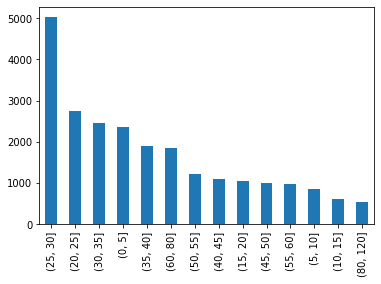

In [237]:
pd.value_counts(df['Age_bin_custom_range']).plot.bar()

## Adaptive Binning

Quantile based binning is a good strategy to use for adaptive binning. Quantiles are specific values or cut-points which help in partitioning the continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals. 

## Data Generator

In [24]:
def gen(df, batch_size = 100, w=160, h=160):
  while True:
    samples_range = len(df)//batch_size
    for i in range(samples_range) :
      start = i * batch_size
      end = start + batch_size
      y = [
            np.array(df['age'].loc[start:end-1]), 
            np.array(df['gender'].loc[start:end-1]), 
            np.array(df['race'].loc[start:end-1])
          ]
      x =[]
      for j in range (start, end):
        img = cv2.imread(df.loc[j]['img_path'],cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img =cv2.resize(img, (w,h) )
        x.append(img)
      x = np.array(x)/255.0
      yield x, y

In [25]:
g_train = gen(train, batch_size = 20)

In [26]:
x, y = next(g_train) 

In [27]:
x.shape

(20, 160, 160, 3)

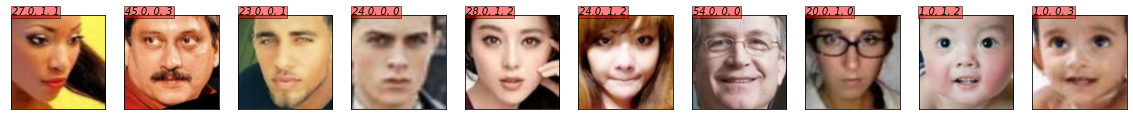

In [28]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}, {}, {}'.format(np.round((y[0][i]*iqr+q1),3), y[1][i], y[2][i]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Model3 : FaceNet + 3xFC

In [29]:
# https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn
# https://drive.google.com/file/d/1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1/view?usp=sharing
# !gdown --id "1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1"

In [30]:
facenet = tf.keras.models.load_model('../pretrained_models/facenet_keras.h5')
# summarize input and output shape
print(facenet.inputs)
print(facenet.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


In [31]:
# freez pretrained layers
for i in range(len(facenet.layers)):
    facenet.layers[i].trainable = False

In [32]:
# build base model
img_input = facenet.input
base_model = facenet.output
base_model = tf.keras.layers.Dense(1024,activation='linear')(base_model)
#------------------------------- Age Model ----------------------------------------
age_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(96,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(32,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(1,activation='linear',name='age_out')(age_base)
age_model = tf.keras.models.Model(img_input, age_base)
#---------------------------------------------------------------------
gender_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(96,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(32,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(1,activation='sigmoid',name='gender_out')(gender_base)
gender_model = tf.keras.models.Model(img_input, gender_base)
#---------------------------------------------------------------------
race_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(96,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(32,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(no_race_classes,activation='softmax',name='race_out')(race_base)
race_model = tf.keras.models.Model(img_input, race_base)
#---------------------------------------------------------------------
model = tf.keras.models.Model(inputs=[img_input], outputs=[age_base, gender_base, race_base])
model.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])
# model.summary()

In [65]:
import datetime
RUN_NAME = 'model_AGR_facenet'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                      save_best_only=True, verbose=1) # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=50, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint]


In [72]:
model = tf.keras.models.load_model('../logs/models/model_AGR_facenet.h5')

In [73]:
# freez pretrained layers
for i in range(len(model.layers)):
  model.layers[i].trainable = True

In [74]:
epoches = 100
batch_size = 32
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,
                  epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/100
594/594 [==============================] - ETA: 0s - loss: 0.9010 - age_out_loss: 0.2839 - gender_out_loss: 0.1667 - race_out_loss: 0.4504 - age_out_acc: 0.0309 - gender_out_acc: 0.9281 - race_out_acc: 0.8508
Epoch 00001: val_loss did not improve from 0.87593
594/594 [==============================] - 46s 77ms/step - loss: 0.9010 - age_out_loss: 0.2839 - gender_out_loss: 0.1667 - race_out_loss: 0.4504 - age_out_acc: 0.0309 - gender_out_acc: 0.9281 - race_out_acc: 0.8508 - val_loss: 0.8788 - val_age_out_loss: 0.2390 - val_gender_out_loss: 0.1777 - val_race_out_loss: 0.4622 - val_age_out_acc: 0.0347 - val_gender_out_acc: 0.9298 - val_race_out_acc: 0.8525
Epoch 2/100
594/594 [==============================] - ETA: 0s - loss: 0.8911 - age_out_loss: 0.2819 - gender_out_loss: 0.1670 - race_out_loss: 0.4421 - age_out_acc: 0.0313 - gender_out_acc: 0.9267 - race_out_acc: 0.8477
Epoch 00002: val_loss did not improve from 0.87593
594/594 [==============================] - 44s 74ms/ste

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# from google.colab import files

uploaded = files.upload()
img_name = list(uploaded.keys())[0]
#-----------------------------------
img = cv2.imread(img_name,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img =cv2.resize(img, (w,h) )/255.0
img = np.expand_dims(img, 0)
#--------------------------------------
pred = model.predict(img)
age = round((pred[0][0][0]*sigma)+mu)
gender =  int(np.round((pred[1][0][0]),0))
if gender == 0:
  gender = 'M'
else:
  gender = 'F'
race_idx = np.argmax(pred[1][0][0])
race_list = ['White', 'Black', 'Asian', 'Indian', 'Others']
race = race_list[idx]
#--------------------------------------
p_id=0
imshow(img[p_id])
pred = model3.predict([[img[p_id]]])
print(age, gender, race)

In [ ]:
%tensorboard --logdir logs/fit

# Xception

In [19]:
xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(160, 160, 3),
)


In [20]:
xception.output.shape

TensorShape([None, 5, 5, 2048])

In [24]:
# build base model
img_input = xception.input
base_model = xception.output
base_model = tf.keras.layers.Flatten()(base_model)
base_model = tf.keras.layers.Dense(1024,activation='linear')(base_model)
#------------------------------- Age Model ----------------------------------------
age_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(96,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(32,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(1,activation='linear',name='age_out')(age_base)
age_model = tf.keras.models.Model(img_input, age_base)
#---------------------------------------------------------------------
gender_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(96,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(32,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(1,activation='sigmoid',name='gender_out')(gender_base)
gender_model = tf.keras.models.Model(img_input, gender_base)
#---------------------------------------------------------------------
race_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(96,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(32,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(no_race_classes,activation='softmax',name='race_out')(race_base)
race_model = tf.keras.models.Model(img_input, race_base)
#---------------------------------------------------------------------
model = tf.keras.models.Model(inputs=[img_input], outputs=[age_base, gender_base, race_base])
model.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])
# model.summary()

In [34]:
import datetime
RUN_NAME = 'model_xception_AGR_cropped'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                      save_best_only=True, verbose=1) # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=5, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint]

In [35]:
model = tf.keras.models.load_model('../logs/models/model_xception_AGR_cropped.h5')

In [36]:
epoches = 100
batch_size = 32
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,
                  epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/100
594/594 [==============================] - ETA: 0s - loss: 0.9671 - age_out_loss: 0.3132 - gender_out_loss: 0.1653 - race_out_loss: 0.4886 - age_out_acc: 0.0304 - gender_out_acc: 0.9342 - race_out_acc: 0.8398
Epoch 00001: val_loss improved from inf to 1.12384, saving model to ../logs/models/model_xception_AGR_cropped.h5
594/594 [==============================] - 111s 188ms/step - loss: 0.9671 - age_out_loss: 0.3132 - gender_out_loss: 0.1653 - race_out_loss: 0.4886 - age_out_acc: 0.0304 - gender_out_acc: 0.9342 - race_out_acc: 0.8398 - val_loss: 1.1238 - val_age_out_loss: 0.3021 - val_gender_out_loss: 0.2350 - val_race_out_loss: 0.5868 - val_age_out_acc: 0.0319 - val_gender_out_acc: 0.9069 - val_race_out_acc: 0.8099
Epoch 2/100
594/594 [==============================] - ETA: 0s - loss: 0.9020 - age_out_loss: 0.3193 - gender_out_loss: 0.1483 - race_out_loss: 0.4344 - age_out_acc: 0.0304 - gender_out_acc: 0.9429 - race_out_acc: 0.8572
Epoch 00002: val_loss did not improve from

KeyboardInterrupt: 

NameError: name 'iqr' is not defined

# Model 4: FaceNet + 3xCNN

In [ ]:
facenet = tf.keras.models.load_model('../pretrained_models/facenet_keras.h5')
for i in range(len(facenet.layers)):
  facenet.layers[i].trainable = False

In [ ]:
# build base model
w, h = 32, 32
no_race_classes = 5
img_input = facenet.input
base_model = facenet.output
base_model = Dense(w*h,activation='linear')(base_model)
base_model = Reshape((w,h,1))(base_model)
#------------------------------- Age Model ----------------------------------------
age_base = Conv2D(32,3,activation=None, padding='same')(base_model)
age_base = LeakyReLU()(age_base)
age_base = Dropout(0.5)(age_base)
age_base = BatchNormalization()(age_base)
age_base = Conv2D(64,3,activation=None, padding='same')(age_base)
age_base = LeakyReLU()(age_base)
age_base = Dropout(0.5)(age_base)
age_base = BatchNormalization()(age_base)
age_base = Conv2D(96,3,activation=None, padding='same')(age_base)
age_base = LeakyReLU()(age_base)
age_base = Dropout(0.5)(age_base)
age_base = BatchNormalization()(age_base)
age_base = Flatten()(age_base)
age_base = Dense(1024, activation=None)(age_base)
age_base = LeakyReLU()(age_base)
age_base = Dropout(0.5)(age_base)
age_base = Dense(1, activation='linear',name='age')(age_base)
age_model = Model(img_input, age_base)
#------------------------------- Gender Model ----------------------------------------
gender_base = Conv2D(32,3,activation='relu', padding='same')(base_model)
gender_base = Dropout(0.5)(gender_base)
gender_base = BatchNormalization()(gender_base)
gender_base = Conv2D(64,3,activation='relu', padding='same')(gender_base)
gender_base = Dropout(0.5)(gender_base)
gender_base = BatchNormalization()(gender_base)
gender_base = Conv2D(96,3,activation='relu', padding='same')(gender_base)
gender_base = Dropout(0.5)(gender_base)
gender_base = BatchNormalization()(gender_base)
gender_base = Flatten()(gender_base)
gender_base = Dense(1024, activation='relu')(gender_base)
gender_base = Dense(1, activation='sigmoid',name='gender')(gender_base)
gender_model = Model(img_input, gender_base)
#------------------------------- Race Model ----------------------------------------
race_base = Conv2D(32,3,activation='relu', padding='same')(base_model)
race_base = Dropout(0.5)(race_base)
race_base = BatchNormalization()(race_base)
race_base = Conv2D(64,3,activation='relu', padding='same')(race_base)
race_base = Dropout(0.5)(race_base)
race_base = BatchNormalization()(race_base)
race_base = Conv2D(96,3,activation='relu', padding='same')(race_base)
race_base = Dropout(0.5)(race_base)
race_base = BatchNormalization()(race_base)
race_base = Flatten()(race_base)
race_base = Dense(1024, activation='relu')(race_base)
race_base = Dense(no_race_classes, activation='softmax',name='race')(race_base)
gender_model = Model(img_input, race_base)
#---------------------------------------------------------------------
model = Model(inputs=[img_input], outputs=[age_base, gender_base, race_base])
model.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])

In [ ]:
import datetime
RUN_NAME = 'model4_leaky_age_robust_scaler_mae_b_c'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                      save_best_only=True, verbose=1) # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=50, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint]


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
# !mkdir models
!rm -rf "../logs/fit/"
!mkdir "../logs/fit"

In [ ]:
epoches = 500
batch_size = 100
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,epochs=epoches
                   ,shuffle=True, verbose=1, callbacks=callbacks)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ../logs/fit/

# Test Model

In [98]:
RUN_NAME

'model_AGR_facenet'

In [ ]:
del model

In [99]:
model = tf.keras.models.load_model('../logs/models/{}.h5'.format(RUN_NAME))

In [97]:
batch_size=1
validation_steps = len(valid)//batch_size
valid_set = gen(valid, batch_size = batch_size)
valid_evaluation = model.evaluate(valid_set, steps=validation_steps, verbose=1 )

4673/4673 [==============================] - 96s 21ms/step - loss: 0.8788 - age_out_loss: 0.2390 - gender_out_loss: 0.1776 - race_out_loss: 0.4621 - age_out_acc: 0.0347 - gender_out_acc: 0.9298 - race_out_acc: 0.8526


In [108]:
batch_size=1
validation_steps = len(valid)//batch_size
valid_set = gen(valid, batch_size = batch_size)
valid_pred = model.predict(valid_set, steps=validation_steps, verbose=1)

4673/4673 [==============================] - 71s 15ms/step


In [109]:
from sklearn import metrics as mc

In [146]:
def pred_transform(pred):
    iqr, q1 = 22, 23
    pred[0] = np.round((pred[0] * iqr)+q1, 0).astype('int')
    pred[1] = pred[1]>0.5
    pred[2] = np.argmax(pred[2], axis=1).reshape(-1,1)
    
    pred_dict = {'age':list(pred[0].ravel()), 'gender':list(pred[1].ravel()), 'race':list(pred[2].ravel())}
    pred_df = pd.DataFrame(pred_dict)
    pred_df.gender.replace(True, 'F', inplace=True)
    pred_df.gender.replace(False, 'M', inplace=True)
    pred_df.race.replace(0, 'US/EU', inplace=True)
    pred_df.race.replace(1, 'African', inplace=True)
    pred_df.race.replace(2, 'Asian', inplace=True)
    pred_df.race.replace(3, 'Indean', inplace=True)
    pred_df.race.replace(4, 'Other', inplace=True)
    
    return pred, pred_df


In [111]:
valid_pred, _ = pred_transform(valid_pred)

In [112]:
mc.mean_absolute_error(valid.age*iqr+q1, valid_pred[0])

5.178258078322277

In [113]:
print(mc.classification_report(valid.gender,valid_pred[1]))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2465
           1       0.94      0.91      0.92      2208

    accuracy                           0.93      4673
   macro avg       0.93      0.93      0.93      4673
weighted avg       0.93      0.93      0.93      4673



In [114]:
print(mc.classification_report(valid.race,valid_pred[2]))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2056
           1       0.84      0.93      0.88       891
           2       0.94      0.89      0.91       651
           3       0.79      0.78      0.79       765
           4       0.51      0.27      0.36       310

    accuracy                           0.85      4673
   macro avg       0.79      0.76      0.77      4673
weighted avg       0.84      0.85      0.84      4673



In [115]:
test_imgs = glob('../dataset/test_imgs/*')
x = []
for i in range(len(test_imgs)):
#     im =Image.open(test_imgs[i]).resize((160,160))
    im = cv2.resize(cv2.imread(test_imgs[i]), (160, 160))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    x.append(im)

x = np.array(x)/255.0

pred = model.predict(x)
_, pred = pred_transform(pred)

n = len(test_imgs)  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}, {}, {}'.format(pred.age.loc[i], pred.gender.loc[i], pred.race.loc[i]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

(6, 160, 160, 3)

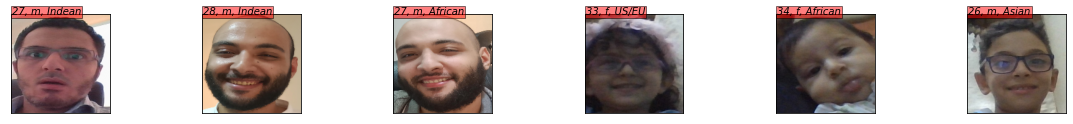